In [282]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
from math import log
import ast
import matplotlib.pyplot as plt

In [283]:
dados = pd.read_csv('../data/estadao_noticias_eleicao.csv')
dados = dados.replace(np.nan, '', regex=True)

## Visão geral dos dados

In [284]:
dados.head()

,timestamp,titulo,subTitulo,conteudo,url,idNoticia
0,2014-12-31T00:00:00Z,PT espera 30 mil pessoas em festa na Esplanada,Objetivo é demonstrar apoio popular a Dilma e ...,BRASÍLIA - Após o desgaste provocado com o lan...,"http://politica.estadao.com.br/noticias/geral,...",1
1,2014-12-31T00:00:00Z,Alckmin toma posse de olho no Planalto,Governador reeleito tenta amarrar tucanos paul...,"Reeleito em outubro, o governador tucano Geral...","http://politica.estadao.com.br/noticias/geral,...",2
2,2014-12-31T00:00:00Z,Seis obstáculos e desafios do segundo mandato ...,"Em meio a escândalo de corrupção, presidente t...",1. Rearranjo das contas A nova equipe econôm...,"http://politica.estadao.com.br/noticias/geral,...",3
3,2014-12-31T00:00:00Z,,Veja as principais fotos do dia e dos eventos ...,,"http://fotos.estadao.com.br/fotos/politica,dil...",4
4,2014-12-31T00:00:00Z,,Veja as principais fotos do dia e dos eventos ...,,"http://fotos.estadao.com.br/fotos/politica,dil...",5


In [285]:
print("Os dados tem %d observações e %d colunas" % dados.shape)

Os dados tem 8716 observações e 6 colunas


In [286]:
def calculaTF(documento, termo):
    return len(list(filter((lambda x: x.lower() == termo), documento)))

## Cálculo dos índices invertidos

Gera a estrutura de dados que representa o índice de busca, Tal estrutura é dicionário de dicionários na forma:

**{termo : {docID : frequência}}**

In [288]:
def calcula_indices_invertidos(data):
    indices = {}
    for index, row in data.iterrows():
        titulo = TextBlob(row["titulo"]).words
        subTitulo = TextBlob(row["subTitulo"]).words
        conteudo = TextBlob(row["conteudo"]).words
        
        texto = titulo + subTitulo + conteudo
        
        for palavra in texto:
            palavra_low = palavra.lower()
            if(palavra_low in indices):
                temp = indices[palavra_low]
                if(row["idNoticia"] not in temp):
                    temp[row["idNoticia"]] = calculaTF(texto, palavra_low)
                    indices[palavra_low] = temp
            else:
                indices[palavra_low] = {row["idNoticia"]: calculaTF(texto, palavra_low)}
    return(indices)

indices_invertidos = calcula_indices_invertidos(dados)

## Cálcudo do IDF

A função abaixo calcula do IDF (Inverse document frequency) de uma palavra base se dados

In [290]:
n_documentos = dados.shape[0]

def idf(palavra):
    palavra = palavra.lower()
    k = len(indices_invertidos[palavra])
    idf = log((n_documentos+1)/k)
    
    return(idf)

## Cálculo da relevância de um documento para uma consulta

As funções abaixo são responsáveis por calcular o valor de relevância de um documento em função de uma query. Cada uma delas segue as seguintes estratégias, respectivamente:

* Representação binária
* TF (Term frequency)
* TF-IDF
* BM25

Tais valores são utilizados para ranquear os documentos.

In [466]:
def calcula_binario(query, documento):
    total = 0
    for palavra in query:
        if(palavra in indices_invertidos):
            temp = indices_invertidos[palavra]
            if(documento in temp):
                total += 1
    return(total) 

def calcula_tf(query, documento):
    total = 0
    for palavra in query:
        if(palavra in indices_invertidos):
            temp = indices_invertidos[palavra]
            if(documento in temp):
                total += temp[documento]
    return(total)

def calcula_tf_idf(query, documento):
    total = 0
    for palavra in query:
        if(palavra in indices_invertidos):
            temp = indices_invertidos[palavra]
            if(documento in temp):
                total += (temp[documento] * idf(palavra))
    return(total)

def calcula_bm25(query, documento, k_low = 1.9, k_high= 2.4):
    total = 0
    for palavra in query:
        if(palavra in indices_invertidos):
            temp = indices_invertidos[palavra]
            if(documento in temp):
                tf = temp[documento]
                k = np.random.uniform(low=k_low, high=k_high)
                total += idf(palavra) * ((tf * (k+1)) / (tf+k))
    return(total)

## Busca de Documentos

A função *busca_documentos* retorna uma lista de documentos que contém todos em termos presentes na consulta, funcionando como um **busca AND**.

In [305]:
def busca_documentos(query):
    if(query[0] in indices_invertidos):
        documentos = set(indices_invertidos[query[0]])
    else: return([])
    for palavra in query[1:]:
        if(palavra in indices_invertidos):
            documentos = documentos & set(indices_invertidos[palavra])
    return(list(documentos))

## Funções de Ranking

O conjunto de funções abaixo é responsável por retornar os 5 documentos mais relevantes para uma consulta de acordo com as seguintes estratégias, respectivamente:

* Representação binária
    * Os documentos são ordenados de acordo com o número da palavras que casam com a query
* TF (Term frequency)
    * O critério de ordenação é a frequência dos termos da query no documento
* TF-IDF
    * Funciona como o TF mas penaliza a ocorrência de palavras comuns
* BM25
    * Funciona como o TF-IDF mas adiciona uma penalização de modo a evitar a dominância de um único termo sobre os demais


São retornados os 5 documentos mais relevantes em cada busca.

In [467]:
def ranking_binario(query):
    docs = busca_documentos(query)
    bin_docs = []
    for doc in docs:
        bin_docs.append(calcula_binario(query, doc))
    docs_ordenado = [docs[i] for i in np.argsort(bin_docs)[::-1]]
    return(docs_ordenado[0:5])

def ranking_tf(query):
    docs = busca_documentos(query)
    tf_docs = []
    for doc in docs:
        tf_docs.append(calcula_tf(query, doc))
    docs_ordenado = [docs[i] for i in np.argsort(tf_docs)[::-1]]
    return(docs_ordenado[0:5])

def ranking_tf_idf(query):
    docs = busca_documentos(query)
    idf_docs = []
    for doc in docs:
        idf_docs.append(calcula_tf_idf(query, doc))
    docs_ordenado = [docs[i] for i in np.argsort(idf_docs)[::-1]]
    return(docs_ordenado[0:5])

def ranking_BM25(query, k_low = 1.9, k_high = 2.4):
    docs = busca_documentos(query)
    bm25_docs = []
    for doc in docs:
        bm25_docs.append(calcula_bm25(query, doc, k_low = k_low, k_high = k_high))
    docs_ordenado = [docs[i] for i in np.argsort(bm25_docs)[::-1]]
    return(docs_ordenado[0:5])

### Lista de consultas que serão realizadas

In [395]:
consultas = [
    ["segundo", "turno"],
    ["lava", "jato"],
    ["projeto", "de", "lei"],
    ["compra", "de", "voto"],
    ["ministério", "público"]
]

## Documentos retornados

Observaremos agora os documentos retornados por cada ranking

### Representação binária

In [398]:
for c in consultas:
    print(c, "=",ranking_binario(c))

['segundo', 'turno'] = [2047, 833, 2754, 2755, 709]
['lava', 'jato'] = [2023, 488, 452, 454, 464]
['projeto', 'de', 'lei'] = [1023, 4791, 679, 172, 8371]
['compra', 'de', 'voto'] = [6783, 7718, 6946, 3234, 5286]
['ministério', 'público'] = [8185, 2547, 516, 514, 513]


### TF

In [399]:
for c in consultas:
    print(c, "=",ranking_tf(c))

['segundo', 'turno'] = [2744, 7, 2112, 7672, 2388]
['lava', 'jato'] = [353, 163, 2807, 360, 127]
['projeto', 'de', 'lei'] = [7, 3942, 7017, 1250, 6942]
['compra', 'de', 'voto'] = [3942, 7017, 5129, 2047, 748]
['ministério', 'público'] = [6798, 8018, 6244, 6965, 6550]


### TF-IDF

In [400]:
for c in consultas:
    print(c, "=",ranking_tf_idf(c))

['segundo', 'turno'] = [2744, 2112, 7672, 1235, 2388]
['lava', 'jato'] = [353, 163, 2807, 127, 876]
['projeto', 'de', 'lei'] = [7017, 2853, 7, 2232, 3171]
['compra', 'de', 'voto'] = [2047, 7017, 7343, 7293, 5129]
['ministério', 'público'] = [6798, 8018, 6244, 6965, 6550]


### BM25

In [401]:
for c in consultas:
    print(c, "=",ranking_BM25(c))

['segundo', 'turno'] = [2744, 2112, 7672, 2388, 2178]
['lava', 'jato'] = [353, 163, 2807, 127, 876]
['projeto', 'de', 'lei'] = [2853, 3171, 2232, 6699, 6461]
['compra', 'de', 'voto'] = [2200, 2047, 2178, 7343, 7293]
['ministério', 'público'] = [6798, 8018, 6244, 6965, 6550]


## Avaliação

Os resultados serão avaliados segundo o gabarito fornecido, que contém os resultados esperados para cada estratégia de busca e também o resultado obtido com a busca google.

### Métrica

A métrica usada para a avaliação será o **MAP** (Mean Average Precision).

In [228]:
gabarito = pd.read_csv('../data/gabarito.csv')

In [373]:
# from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=10):
    if (len(predicted)>k):
        predicted = predicted[:k]
        
    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if (not actual):
        return 0.0

    return (score / min(len(actual), k))

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

### Busca dos documentos

Busca os documentos mais relevantes, segundo cada uma das consultas acima, para as estratégias de recuperação implementadas.

In [468]:
result_rep_binaria = []
result_tf = []
result_tf_idf = []
result_bm25 = []
for query in consultas:
    result_rep_binaria.append(ranking_binario(query))
    result_tf.append(ranking_tf(query))
    result_tf_idf.append(ranking_tf_idf(query))
    result_bm25.append(ranking_BM25(query))

### Valores do gabarito

Recupera os valores esperados das consultas para utilizar na avaliação das mesmas

In [469]:
expected_rep_binaria = gabarito["busca_binaria"].tolist()
expected_tf = gabarito["tf"].tolist()
expected_tf_idf = gabarito["tfidf"].tolist()
expected_bm25 = gabarito["bm25"].tolist()
expected_google = gabarito["google"].tolist()

for l in range(len(expected_rep_binaria)):
    expected_rep_binaria[l] = ast.literal_eval(expected_rep_binaria[l])
    expected_tf[l] = ast.literal_eval(expected_tf[l])
    expected_tf_idf[l] = ast.literal_eval(expected_tf_idf[l])
    expected_bm25[l] = ast.literal_eval(expected_bm25[l])
    expected_google[l] = ast.literal_eval(expected_google[l])

### Avaliação de acordo com gabarito

In [470]:
print("Representação Binária:", mapk(expected_rep_binaria, result_rep_binaria, k=5))
print("TF:", mapk(expected_tf, result_tf, k=5))
print("TF-IDF:", mapk(expected_tf_idf, result_tf_idf, k=5))
print("BM25:", mapk(expected_bm25, result_bm25, k=5))

Representação Binária: 0.0
TF: 0.952
TF-IDF: 0.7206666666666667
BM25: 0.5713333333333332


### Avaliação de acordo com a busca google

In [471]:
print("Representação Binária:", mapk(expected_google, result_rep_binaria, k=5))
print("TF:", mapk(expected_google, result_tf, k=5))
print("TF-IDF:", mapk(expected_google, result_tf_idf, k=5))
print("BM25:", mapk(expected_google, result_bm25, k=5))

Representação Binária: 0.0
TF: 0.028000000000000004
TF-IDF: 0.064
BM25: 0.15066666666666667


### Buscando o melhor k para o BM25

Abaixo tentaremos identificar o melhor valor para o k do algoritmo BM25, para tal, observaremos o valor da métrica **MAP** para 100 valores de k, entre 1 e 10, variando 0.1 em cada valor.

In [472]:
bm25_gabarito = []
bm25_google = []
for k in range(10, 101):
    result_bm25 = []
    for query in consultas:
        result_bm25.append(ranking_BM25(query, k_low = (k/10), k_high = (k/10)+0.5))
    bm25_gabarito.append(mapk(expected_bm25, result_bm25, k=5))
    bm25_google.append(mapk(expected_google, result_bm25, k=5))

A figura abaixo apresenta os da métrica MAP, variando o valor de k, para os dois gabaritos disponíveis.

A linha azul representa o map considerando o gabarito comum e a laranja o gabarito da busca google.

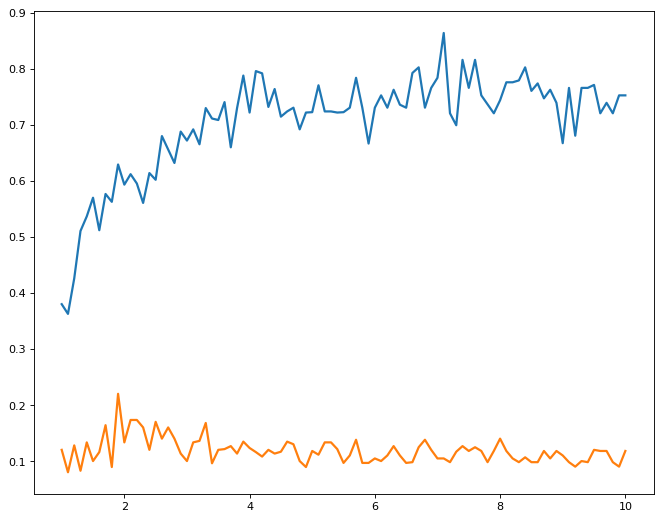

In [473]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

df=pd.DataFrame({"k" : np.linspace(1, 10, 91), "gabarito":bm25_gabarito, "google": bm25_google})

plt.plot('k', 'gabarito', data=df, marker='', linewidth=2)
plt.plot('k', 'google', data=df, marker='', linewidth=2)

In [454]:
df.sort_values(by=['google', 'gabarito'], ascending=False).head()

,k,gabarito,google
9,1.9,0.582000,0.184667
25,3.5,0.697333,0.180000
13,2.3,0.711333,0.160000
17,2.7,0.687333,0.153333
15,2.5,0.680000,0.150667


De acordo com os resultados obtidos o valor de k variando uniformemente entre 1.9 e 2.4 apresenta os melhores resultados para o gabarito comum e fica bastante próximo do melhor resultado para o gabarito google.

Logo, esse será o intervalo usado para o k.

## Conclusões

O gráfico abaixo apresenta os valores obtidos com a avaliação de cada modelo de recuperação de informação.

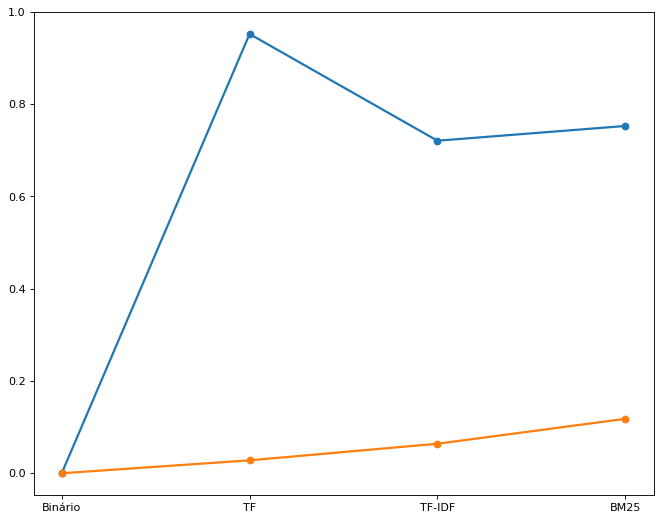

In [474]:
resultados = pd.DataFrame({"modelo": ["Binário", "TF", "TF-IDF", "BM25"], 
                           "gabarito": [mapk(expected_rep_binaria, result_rep_binaria, k=5),
                                        mapk(expected_tf, result_tf, k=5),
                                        mapk(expected_tf_idf, result_tf_idf, k=5),
                                        mapk(expected_bm25, result_bm25, k=5)],
                          "google": [mapk(expected_google, result_rep_binaria, k=5),
                                     mapk(expected_google, result_tf, k=5),
                                     mapk(expected_google, result_tf_idf, k=5),
                                     mapk(expected_google, result_bm25, k=5)]})

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot('modelo', 'gabarito', data=resultados, marker='o', linewidth=2)
plt.plot('modelo', 'google', data=resultados, marker='o', linewidth=2)



Como esperado, a representação binária tem o pior desempenho de todos.

É surpendente com o TF obteve um bom resultado com o gabarito comum, ainda que os outros dois tenham tido um bom resultado nesse mesmo gabarito.

Quanto ao gabarito google o comportamento se dá como esperado, quanto mais refinado é o modelo de recuperação da informação, melhor é o ranking gerado, mesmo que com valores baixos.